# Predictive Modeling for Library Migration

## Hypothesis

* H1: If many other projects have removed a library, it will be more likely for a project to migrate away from this library
* H2: If many other projects have migrated from a library, it will be more likely for a project to migrate away from this library
* H3: If the use of a library do not align well with current best practices, it will more likely for a project to migrate away from this library
* H4: If a project have simultaneous use of same-domain libraries, it will be more likely to consolidate its usage to a single library
* H5: A project is more likely to use a library that its upstream projects are already using
* H6: If a library is not actively maintained, it will be more likely for a project to migrate away from this library
* H7: If a library has unpatched security vulnerabilities, it will be more likely for a project to migrate away from this library
* H8: If a library has an unusual license, it will be more likely for a project to migrate away from this library

## Model

首先，我们确立一组感兴趣的库集合$L$（$L$可能是若干个同一领域的库）。我们对这些库在大规模的项目集合$\mathcal{P}$上提取所有的依赖项变更

$$
\begin{align}
\Delta L   &= \{\langle t,p,c,f,l^-,l^+,v^-,v^+ \rangle\}, p\in \mathcal{P}, x \in \Delta L \Rightarrow x.l^- \in L \lor x.l^+ \in L\\
\Delta L^+ &= \{x | x \in \Delta L \land x.l^+ \in L \land x.l^- = \emptyset \}\\
\Delta L^- &= \{x | x \in \Delta L \land x.l^- \in L \land x.l^+ = \emptyset\}
\end{align}
$$

其中，$t$是时间，$c$是Commit，$f$是被修改的依赖配置文件。

我们使用逻辑回归模型来拟合一个函数$f$，满足

$$
\begin{cases}
f(x) = 1, x \in \Delta L^+ \\
f(x) = 0, x \in \Delta L^-
\end{cases}
$$

对每个$x \in \Delta L$，定义其被添加或被删除的库为$l$，计算如下特征

1. 项目做出变更的时间$t$减去$l$最近的上一次发布的时间。（刻画库是否正在被维护，验证H6）
2. 项目做出变更的时间$t$减去$l$的第一次发布的时间。（刻画库的老旧程度，验证H6）
3. 项目做出变更时，$l$能够查询到的安全漏洞的数量。（刻画库的安全漏洞情况，验证H7）
4. $l$的许可证情况，按$L$集合里的许可证数量进行one-hot encoding。（验证H8）
5. 项目做出变更时，项目的间接依赖里是否已经包含$l$。（验证H5）
6. 项目做出变更时，项目的其他依赖配置文件里是否已经声明了$l$。(验证H4）
7. 项目做出变更时，$l$在$\mathcal{P}$中的全局留存率（1 - 被删除的次数 / 被添加的次数）。（验证H1）
8. 项目做出变更时，$l$在已确认迁移中的流入比率（迁移图上入度 / 出度）。（验证H2）
9. 项目做出变更时，$l$与剩下所有依赖的Pointwise Mutual Information (PMI)均值
    $$
    \frac{1}{|x.f|}\sum_{l'\in x.f} \log \frac{p(l,l')}{p(l)p(l')}
    $$
    公式中概率使用$\mathcal{P}$中所有依赖配置文件来估计。（验证H3）

备注：为了计算上述指标，需要额外研究一下如何获取安全漏洞数据。可能考虑：GitHub Advisories，或参考已有研究。

In [1]:
import datautil
dep_change = datautil.select_dependency_changes_all()
print(len(dep_change))


3329249


In [1]:
import model
import numpy as np
lib = "org.json:json"
index1 = []
f = []
migrations_to_lib = model.get_migration_to_library(lib).values
migrations_from_lib = model.get_migration_from_library(lib).values
for migration in migrations_to_lib:
    index1.append(model.index_1(migration, lib))
    f.append(1)
for migration in migrations_from_lib:
    index1.append(model.index_1(migration, lib))
    f.append(0)
print(len(index1))

/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


5134


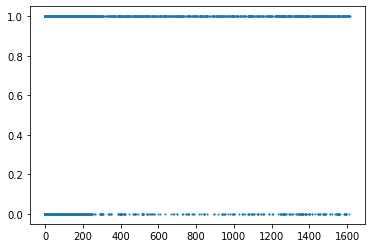